In [1]:
from src.Car import Car
from src.Obstacle import Obstacle
from src.utils import draw
from src.simulation import simulation
from src.LQRController import LQRController
from src.PIDController import PID_Controller
from src.LuenbergerObserver import LuenbergerObserver

In [2]:
import time
from IPython.display import clear_output

import numpy as np


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [4]:
from scipy.linalg import expm, solve_discrete_are


In [5]:
start   = [(100, 100), (0, 0), 0]

targets = np.array([[900, 200, 0, 0],
                    [300, 500, 0, 0],
                    [400, 100, 0, 0],
                    [100, 900, 0, 0]])
targets = np.array([#[400, 165, 0, 0], 
                    [900, 900, 0, 0]])

obstacles = [[(500, 500), 0]]
obstacles = [[(300, 300), 0], [(700, 600), 0], [(500, 400), 0]]

# obstacles = []

In [6]:
initial_guess = [0, 0, 0]   # User can modify this as needed

# PID = PID_Controller(start, obstacles, targets, reference=5, simulation_time=1000)
PID = PID_Controller(start, obstacles, targets, reference=5, simulation_time=1000, kalman=False)
Kp, Ki, Kd = PID.optimize_pid(initial_guess)

Optimization terminated successfully.
         Current function value: 1502.177358
         Iterations: 3
         Function evaluations: 212


In [7]:
# PID
# states, u_list, target_list = simulation(start, obstacles, targets, PID, Kp=Kp, Ki=Ki, Kd=Kd, simulation_time=1000)
states, u_list, target_list = simulation(start, obstacles, targets, PID, Kp=Kp, Ki=Ki, Kd=Kd, simulation_time=1000, kalman=False)

# states, u_list, target_list = simulation(start, obstacles, targets, simulation_time=1000)
# states, u_list, target_list = simulation(start, obstacles, targets, simulation_time=1000, kalman=False)

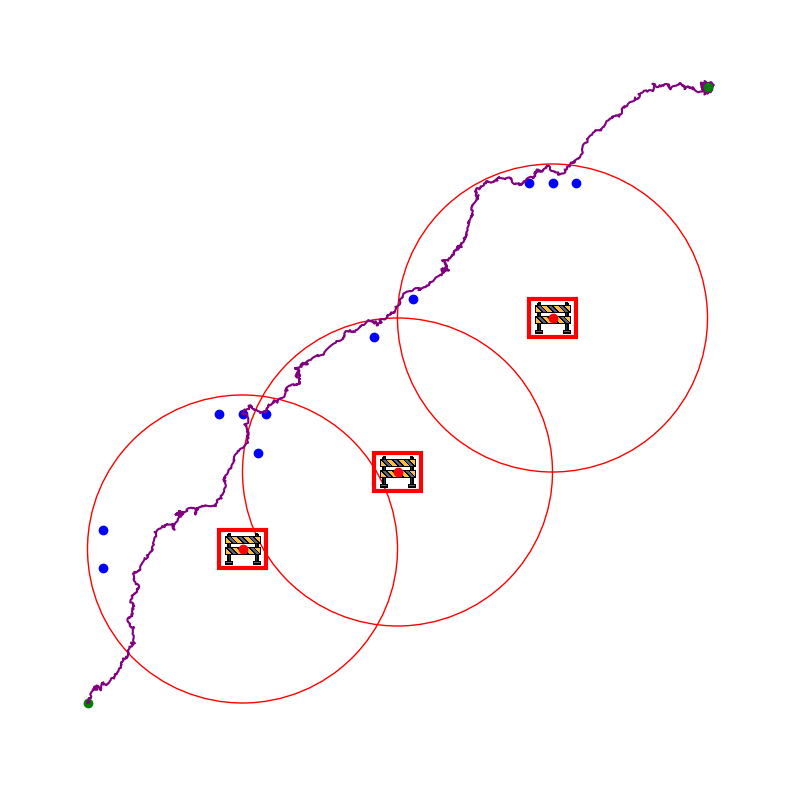

In [8]:
obstacles_draw = np.array([Obstacle(coords, angle) for coords, angle in obstacles])

image_size = 1000
fig = plt.figure(figsize=(image_size / 100, image_size / 100), dpi=100)
ax = plt.gca()
ax.plot(states[:, 0], states[:, 1], color="purple")
ax.scatter(start[0][0], start[0][1], color="green")
for obstacle in obstacles_draw:
    obstacle.draw(ax)
    ax.add_patch(Circle(obstacle.get_coords(), 200, facecolor="None", edgecolor="red"))
ax.scatter(targets[:, 0], targets[:, 1], color="green", zorder=5)
ax.scatter(target_list[:, 0], target_list[:, 1], color="blue")

ax.set_xlim(0, image_size)
ax.set_ylim(0, image_size)
plt.axis("off")
plt.show()

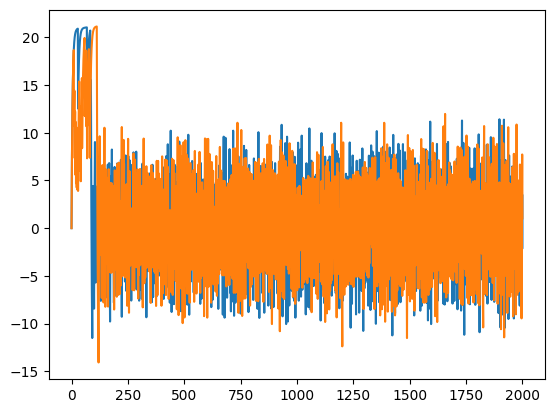

In [14]:
plt.plot(np.arange(states.shape[0]), states[:, 2:])

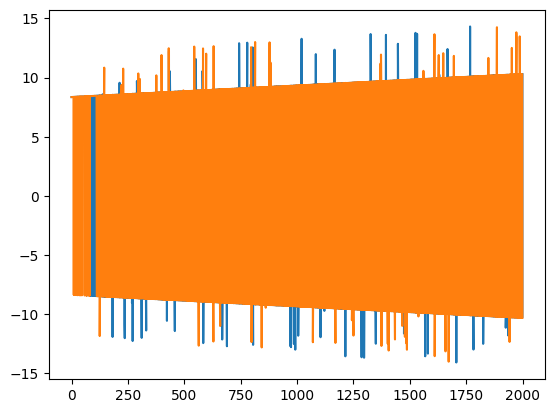

In [15]:
plt.plot(np.arange(u_list.shape[0]), u_list)